# Sepsis Prediction from Clinical Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
%pip install torchinfo
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
directory = "drive/MyDrive/EPOS/training_setA"

# List to store DataFrames
dfs = []

# Loop through each .psv file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".psv"):
        file_path = os.path.join(directory, filename)

        # Extract the patient id
        patient_id = filename.split('.')[0]

        # Read the .psv file into a DataFrame
        df = pd.read_csv(file_path, sep='|')

        # Add a column with patient's ID
        df = df.assign(patient_id = patient_id)

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
del dfs
combined_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,69.11,1,0.0,1.0,-44.60,1,0,p019366
1,95.0,100.0,35.90,110.0,75.00,59.0,14.0,NaN,NaN,NaN,...,NaN,NaN,69.11,1,0.0,1.0,-44.60,2,0,p019366
2,96.0,100.0,36.50,109.0,74.00,59.0,14.0,NaN,0.0,NaN,...,NaN,NaN,69.11,1,0.0,1.0,-44.60,3,0,p019366
3,95.0,NaN,37.00,128.0,87.00,67.0,15.5,NaN,0.0,NaN,...,NaN,NaN,69.11,1,0.0,1.0,-44.60,4,0,p019366
4,79.0,100.0,36.70,112.0,76.00,59.0,14.0,NaN,-1.0,NaN,...,NaN,NaN,69.11,1,0.0,1.0,-44.60,5,0,p019366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794395,71.0,96.0,NaN,108.0,66.67,NaN,26.0,NaN,NaN,NaN,...,NaN,NaN,70.81,1,0.0,1.0,-3.01,44,0,p000434
794396,73.0,94.0,38.00,123.0,69.00,NaN,28.0,NaN,NaN,NaN,...,NaN,NaN,70.81,1,0.0,1.0,-3.01,45,0,p000434
794397,75.0,97.0,NaN,125.0,71.00,NaN,23.0,NaN,NaN,NaN,...,NaN,NaN,70.81,1,0.0,1.0,-3.01,46,0,p000434
794398,77.0,97.0,NaN,122.0,71.33,NaN,33.0,NaN,NaN,NaN,...,NaN,NaN,70.81,1,0.0,1.0,-3.01,47,0,p000434


In [ ]:
# Calculate missing percentage of missing features
stats = combined_df.isna().sum()/len(combined_df)
stats

HR                  0.077419
O2Sat               0.120295
Temp                0.662260
SBP                 0.152149
MAP                 0.102330
DBP                 0.481699
Resp                0.097766
EtCO2               1.000000
BaseExcess          0.895741
HCO3                0.919507
FiO2                0.858011
pH                  0.885292
PaCO2               0.912299
SaO2                0.950390
AST                 0.985065
BUN                 0.918418
Alkalinephos        0.985429
Calcium             0.950261
Chloride            0.916774
Creatinine          0.933580
Bilirubin_direct    0.998512
Glucose             0.877593
Lactate             0.965661
Magnesium           0.922208
Phosphate           0.949524
Potassium           0.891377
Bilirubin_total     0.987752
TroponinI           0.998780
Hct                 0.882249
Hgb                 0.911640
PTT                 0.951529
WBC                 0.924909
Fibrinogen          0.992387
Platelets           0.934828
Age           

That is a lot of NaNs right there. Let's find out what data is represented in a reasonable frequency.

In [ ]:
# Don't include labels, where more than 50% of the data is missing
const_vars = stats[stats<0.5].index

# And drop Unit1 and Unit2 as they are useless (mutually exclusive) features
const_vars = const_vars.drop(["Unit1", "Unit2"])

In [ ]:
df_main = combined_df[const_vars]
df_main # Show hwow the data looks now

,HR,O2Sat,SBP,MAP,DBP,Resp,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,69.11,1,-44.60,1,0,p019366
1,95.0,100.0,110.0,75.00,59.0,14.0,69.11,1,-44.60,2,0,p019366
2,96.0,100.0,109.0,74.00,59.0,14.0,69.11,1,-44.60,3,0,p019366
3,95.0,NaN,128.0,87.00,67.0,15.5,69.11,1,-44.60,4,0,p019366
4,79.0,100.0,112.0,76.00,59.0,14.0,69.11,1,-44.60,5,0,p019366
...,...,...,...,...,...,...,...,...,...,...,...,...
794395,71.0,96.0,108.0,66.67,NaN,26.0,70.81,1,-3.01,44,0,p000434
794396,73.0,94.0,123.0,69.00,NaN,28.0,70.81,1,-3.01,45,0,p000434
794397,75.0,97.0,125.0,71.00,NaN,23.0,70.81,1,-3.01,46,0,p000434
794398,77.0,97.0,122.0,71.33,NaN,33.0,70.81,1,-3.01,47,0,p000434


### Standardize the data

In [ ]:
norm = (df_main.loc[:, df_main.columns != "patient_id"]-df_main.loc[:, df_main.columns != "patient_id"].min())/(df_main.loc[:, df_main.columns != "patient_id"].max()-df_main.loc[:, df_main.columns != "patient_id"].min())
df_main[norm.columns] = norm

<ipython-input-8-65808b69e5d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main[norm.columns] = norm


In [ ]:
del norm

In [ ]:
grouped_by_patients = df_main.groupby("patient_id")

all_windows = []
count = 0
for pid, data in grouped_by_patients:
    # Impute missing values
    data = data.interpolate(limit_direction = "forward").interpolate(limit_direction = "backward")


    cutoff = len(data)
    context_length = 10
    i = 0
    useful = 0
    while (i+context_length + 2 < cutoff):
        useful = 0
        end = i+context_length+1
        i+=1
        window_data = data.iloc[i:end].drop(columns = ["patient_id"])

        if np.isnan(window_data).any().any(): continue
        else: useful = 1

        x_data = window_data.values
        y_label = int(data.iloc[end+1]["SepsisLabel"])

        patient = {}
        patient["X"] = x_data
        patient["y"] = y_label

        all_windows.append(patient)

    count += 1

In [ ]:
del df_main

In [ ]:
X = np.concatenate(np.array(pd.DataFrame(all_windows)["X"])).reshape((len(all_windows), 10, 11))
y = np.array(pd.DataFrame(all_windows)["y"])

In [ ]:
X[1]

array([[0.16923077, 0.975     , 0.3976834 , 0.15714286, 0.07553957,
        0.38235294, 0.81534772, 0.        , 0.96717497, 0.00597015,
        0.        ],
       [0.13846154, 1.        , 0.38996139, 0.16071429, 0.07553957,
        0.11764706, 0.81534772, 0.        , 0.96717497, 0.00895522,
        0.        ],
       [0.17692308, 0.9875    , 0.37837838, 0.16785714, 0.08273381,
        0.32352941, 0.81534772, 0.        , 0.96717497, 0.0119403 ,
        0.        ],
       [0.28461538, 1.        , 0.66409266, 0.34285714, 0.16546763,
        0.19117647, 0.81534772, 0.        , 0.96717497, 0.01492537,
        0.        ],
       [0.14615385, 0.9875    , 0.42857143, 0.17142857, 0.08273381,
        0.17647059, 0.81534772, 0.        , 0.96717497, 0.01791045,
        0.        ],
       [0.14230769, 1.        , 0.37065637, 0.15      , 0.06115108,
        0.25      , 0.81534772, 0.        , 0.96717497, 0.02089552,
        0.        ],
       [0.16153846, 1.        , 0.4015444 , 0.16428571, 0.

In [ ]:
del all_windows

In [ ]:
assert(len(X) == len(y))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# To PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


In [ ]:
assert(len(X_train_tensor) == len(y_train_tensor) and len(X_test_tensor) == len(y_test_tensor))

In [ ]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size and create DataLoader instances for training and testing subsets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):

        # Initialize
        super(LSTMModel, self).__init__()

        # Double bidirectional LSTM RNN layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2, bidirectional=True)

        # Dense hidden
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.fc3 = nn.Linear(32,1)

        # Activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = c0 = torch.zeros(2*self.num_layers, x.size(1), self.hidden_size).to(x.device)
        initial_state = (h0, c0)

        # Forward pass
        out, _ = self.lstm(x, initial_state) # shape (10, 2*hidden_size), forget state, not important for final prediction
        out = out[:, -1, :] # cutoff the last sequence to enforce many-to-one shape (batch, 1, 2*hidden_size)
        out = self.relu(self.fc1(out)) # send through first hidden layer + ReLU
        out = self.relu(self.fc2(out)) # send through second hidden layer + ReLU
        out = self.sigmoid(self.fc3(out)) # send through final hidden layer + Sigmoid $\in [0,1]$
        return out

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, batch_size=1):
    print(f"# of batches: {len(train_loader)}")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # One loop pass = One batch
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            raw_outputs = model(inputs)
            prediction = torch.flatten(raw_outputs)
            loss = criterion(prediction, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Compute accuracy
            total += len(prediction)
            correct += (torch.round(prediction) == labels).sum().item()

        # Print statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

In [ ]:
input_size = X_train.shape[2]  # Number of features per time step
hidden_size = 124
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers).to(device)

# Initialize the model, loss function, and optimizer
criterion = nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # experiment here with learning rate

summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              506,912
├─Linear: 1-2                            30,876
├─Linear: 1-3                            4,000
├─Linear: 1-4                            33
├─ReLU: 1-5                              --
├─Sigmoid: 1-6                           --
Total params: 541,821
Trainable params: 541,821
Non-trainable params: 0

In [ ]:
# Train the model (80% of dataset)
train_model(model,train_loader, criterion, optimizer, 3, batch_size)

# of batches: 4734
Epoch [1/3], Loss: 0.0388, Accuracy: 0.9935
Epoch [2/3], Loss: 0.0335, Accuracy: 0.9948
Epoch [3/3], Loss: 0.0324, Accuracy: 0.9949


In [ ]:
# Evaluate the model (assuming you have test data X_test and y_test)
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    y_true = np.array([])
    y_scores = np.array([])

    with torch.no_grad():
        i = 0
        for inputs, labels in test_loader:
            outputs = torch.flatten(model(inputs))
            predicted = torch.round(outputs)

            y_true = np.append(y_true, labels.cpu().numpy())
            y_scores = np.append(y_scores, (outputs.cpu().numpy()))

            total += len(predicted)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the test set: {(correct / total) * 100}%")
    return y_true, y_scores

# Test the model on test set (20% of dataset)
y, scores = test_model(model, test_loader)

Accuracy on the test set: 99.45866726521344%


In [ ]:
assert(len(y) == len(scores))

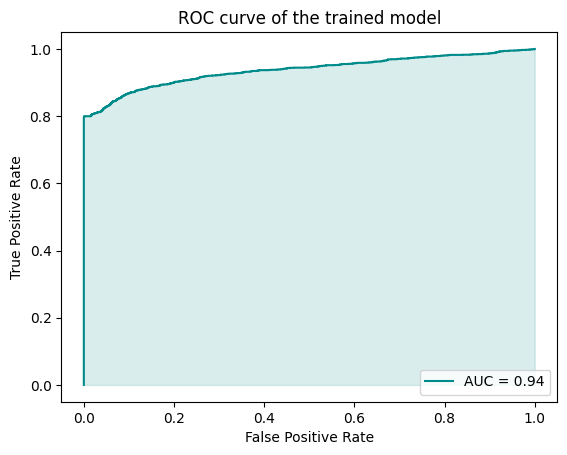

0.8875479978058146


In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y, scores)

# Calculate the area under the ROC curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkcyan', label='ROC Curve')

# Fill area under the curve
plt.fill_between(fpr, tpr, color='darkcyan', alpha=0.15, label='AUC = %0.2f' % roc_auc)

# Set title and labels
plt.title('ROC curve of the trained model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show legend
plt.legend(['AUC = %0.2f' % roc_auc], loc='lower right')

plt.savefig("ROC")


# Show plot
plt.show()

print(metrics.f1_score(y, scores.round(0)))


In [ ]:
# Compute dataset balance
(len(y[y == 1]) / len(y))*100

2.6776165515784474